In [1]:
import numpy as np
from scipy.ndimage import label
def largest_connected_component(img, structure=None):  
    labeled_array, num_features = label(img, structure)
    component_sizes = [np.count_nonzero(labeled_array == label_idx) for label_idx in range(1, num_features + 1)]
    largest_component_idx = np.argmax(component_sizes) + 1

    out = np.zeros(img.shape, np.bool_)  
    out[labeled_array == largest_component_idx] = True
    return out

In [2]:
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes, binary_dilation, binary_erosion
import SimpleITK as sitk
def generate_adc_from_abx(b0_img: sitk.Image, bx_img: sitk.Image, bx_val: int,  threshold: int = None):
    """
    Generates an Apparent Diffusion Coefficient (ADC) image from a b0 and an abX image. 
    abX is the average of the 3 directional bX images.
    """
    # prepare logger
    # logger = Logger.getInstance()
    # if args.debug: logger.setLevel(logging.DEBUG)
    # elif args.verbose: logger.setLevel(logging.INFO)

    b0_arr = sitk.GetArrayFromImage(b0_img)
    bx_arr = sitk.GetArrayFromImage(bx_img)

    # check if image are compatible
    if not b0_arr.shape == bx_arr.shape:
        raise ValueError('The input images shapes differ i.e. {} != {}.'.format(b0_arr.shape, bx_arr.shape))
    # if not b0_img.getSpacing() == bx_img.getSpacing():
        # raise ValueError('The input images voxel spacing differs i.e. {} != {}.'.format(b0_img.GetSpacing(), bx_img.GetSpacing()))
    
    # check if supplied threshold value as well as the b value is above 0
    if threshold is not None and not threshold >= 0:
        raise ValueError('The supplied threshold value must be greater than 0, otherwise a division through 0 might occur.')
    if not bx_val > 0:
        raise ValueError('The supplied b-value must be greater than 0.')
    
    # compute threshold value if not supplied
    if threshold is None:
        b0thr = threshold_otsu(b0_arr, 32) / 6. # divide by 6 to decrease impact
        bxthr = threshold_otsu(bx_arr, 32) / 6.
        if 0 >= b0thr:
            raise ValueError('The supplied b0image seems to contain negative values.')
        if 0 >= bxthr:
            raise ValueError('The supplied bximage seems to contain negative values.')
    else:
        b0thr = bxthr = threshold
    
    # logger.debug('thresholds={}/{}, b-value={}'.format(b0thr, bxthr, args.b))
    
    # threshold b0 + bx DW image to obtain a mask
    # b0 mask avoid division through 0, bx mask avoids a zero in the ln(x) computation
    mask = binary_fill_holes(b0_arr > b0thr) & binary_fill_holes(bx_arr > bxthr)
    
    # perform a number of binary morphology steps to select the brain only
    mask = binary_erosion(mask, iterations=1)
    mask = largest_connected_component(mask)
    mask = binary_dilation(mask, iterations=1)
    
    # logger.debug('excluding {} of {} voxels from the computation and setting them to zero'.format(np.count_nonzero(mask), numpy.prod(mask.shape)))
    
    # compute the ADC
    adc = np.zeros(b0_arr.shape, b0_arr.dtype)
    adc[mask] = -1. * bx_val * np.log(bx_arr[mask] / b0_arr[mask])
    adc[adc < 0] = 0

    adc = sitk.GetImageFromArray(adc)
            
    adc.CopyInformation(b0_img)

    return adc



In [3]:
def generate_adc_in_t2_space(t2_img: sitk.Image, t2_mask: sitk.Image, b0_img: sitk.Image, bx_img: sitk.Image, bx_val: int,  threshold: int = None):
    """
    Generates an Apparent Diffusion Coefficient (ADC) image from a b0 and an abX image using generate_adc_from_abx. 
    Then aligns the b0 to the T2 image with the help of a T2 mask and applies the found transformation to the ADC image.
    Uses SimpleElastix default affine parameter map and Transformix to apply changes to the ADC image.
    """
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(t2_img)
    elastixImageFilter.SetMovingImage(b0_img)
    elastixImageFilter.SetFixedMask(sitk.Cast(t2_mask, sitk.sitkUInt8))
    elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap('affine'))
    elastixImageFilter.SetLogToConsole(False)
    elastixImageFilter.SetLogToFile(False)
    elastixImageFilter.Execute()

    transformParameterMap = elastixImageFilter.GetTransformParameterMap()
    adc = generate_adc_from_abx(b0_img, bx_img, bx_val, threshold)

    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(transformParameterMap)
    transformixImageFilter.SetMovingImage(adc)
    transformixImageFilter.SetLogToConsole(False)
    transformixImageFilter.SetLogToFile(False)
    transformixImageFilter.Execute()

    # Get the result image
    registered_adc = transformixImageFilter.GetResultImage()

    # Clip the values outside the expected range using SimpleITK's Threshold function
    registered_adc = sitk.Threshold(registered_adc, lower=0., upper=float(sitk.GetArrayFromImage(registered_adc).max()), outsideValue=0.)

    return registered_adc

    

In [4]:
def get_b0_bx_from_dwi(dwi_image_path, bvals, bx_val):
    dwi_image = sitk.ReadImage(dwi_image_path)
    if len(dwi_image.GetSize()) != 4:
        raise ValueError("The input image is not a 4D image.")

    # Find indices of b0 and bx images
    b0_indices = np.where(bvals == 0)[0]
    bx_indices = np.where(bvals == bx_val)[0]
    # Check if you found any b0 and bx images
    if not b0_indices.size or not bx_indices.size:
        raise ValueError("No b0 or bx images found in the b-values.")

    # Extract the b0 images (assuming there might be more than one b0 image)
    b0_images = [dwi_image[:, :, :, int(index)] for index in b0_indices]

    # Extract the bx images
    bx_images = [dwi_image[:, :, :, int(index)] for index in bx_indices]
    return b0_images, bx_images

In [10]:
import os
import glob

def verify_bvals(bvals_path, bx_val):
    if bvals_path is None:
        return None
    if not os.path.isfile(bvals_path):
        return None
    bvals = np.loadtxt(bvals_path)
    if not np.where(bvals == bx_val)[0].size or not np.where(bvals == 0)[0].size:
        print(f'Found DWI but no B{bx_val} image. Skipping...')
        return None
    print(f"BVALS FILE: {bvals_path}")
    return bvals

bx_val = 1000

count = 0
adcs= []
for subject_dir in glob.glob('/Volumes/Siren/Prostate_data/*/'):

    # Find T2 Image
    t2_img_path = next(iter(glob.iglob(subject_dir + 'MRI/**/T2.nii.gz', recursive=True)), None)
    t2_mask_path = next(iter(glob.iglob(subject_dir + 'MRI/**/prostate_mask.nii.gz', recursive=True)), None)
    dwi_img_path = next(iter(glob.iglob(subject_dir + 'MRI/**/DWI_clin.nii.gz', recursive=True)), None)
    if dwi_img_path is not None:
        print(dwi_img_path.replace('.nii.gz', '.bval'))
        bvals = verify_bvals(dwi_img_path.replace('.nii.gz', '.bval'), bx_val)

    if dwi_img_path is None or bvals is None: 
        dwi_img_path = next(iter(glob.iglob(subject_dir + 'MRI/**/DWI_Research.nii.gz', recursive=True)), None)
        bvals = verify_bvals(next(iter(glob.iglob(subject_dir + 'MRI/**/BVALS.txt', recursive=True)), None), bx_val)
    medusa_subj_dir = subject_dir.replace('/Volumes/Siren/Prostate_data', '/Volumes/Medusa/Prostate_Data')
    if dwi_img_path is None or bvals is None: # no bvals on Siren :( try Medusa
        print('Could not find DWI_Research on Siren. Trying Medusa')
        dwi_img_path = next(iter(glob.iglob(medusa_subj_dir + 'MRI/**/DWI_clin.nii.gz', recursive=True)), None)
        if dwi_img_path is not None:    
            bvals = verify_bvals(dwi_img_path.replace('.nii.gz', '.bval'), bx_val)
    if dwi_img_path is None or bvals is None: # no valid clinical scans on medusa, try research
        print('Could not find DWI_clin.nii.gz. Trying DWI_Research.nii.gz')
        dwi_img_path = next(iter(glob.iglob(medusa_subj_dir + 'MRI/**/DWI_Research.nii.gz', recursive=True)), None)
        if dwi_img_path is not None:
            bvals = verify_bvals(dwi_img_path.replace('.nii.gz', '.bval'), bx_val)
    
    # if dwi_img_path is None and bvals is not None: # these bvals belong to something!
    #     print('Could not find DWI_clin.nii.gz. Trying DWI_Research.nii.gz')
    #     dwi_img_path = next(iter(glob.iglob(subject_dir + 'MRI/**/DWI_Research.nii.gz', recursive=True)), None)

    # if dwi_img_path is None or  bvals is None: # no bvals on Siren :( try Medusa
    #     print('Could not find BVALS.txt on Siren. Trying Medusa')

    print(t2_img_path)
    print(t2_mask_path)
    print(dwi_img_path)

    if t2_img_path is None or t2_mask_path is None or dwi_img_path is None or bvals is None:
        print('Could not find all images for subject.')
        continue

    if t2_img_path.find('Junk') != -1 or t2_mask_path.find('Junk') != -1 or dwi_img_path.find('Junk') != -1:
        print('Skipping Junk')
        continue
    try:
        b0_img, bx_img = get_b0_bx_from_dwi(dwi_img_path, bvals, bx_val)
    except ValueError:
        print(f'Could not find B{bx_val} image. Skipping...')
        continue
    except IndexError:
        print(f'Could not find proper bvals file. Skipping...')
        continue
    if len(b0_img) > 1 or len(bx_img) > 1:
        print('SCARY! Should not be multiple images of a given b val Stopping!')
        break
    else:
        b0_img = b0_img[0]
        bx_img = bx_img[0]

    t2_img = sitk.ReadImage(t2_img_path)
    t2_mask = sitk.ReadImage(t2_mask_path)
    t2_mask = sitk.Resample(t2_mask, t2_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, t2_mask.GetPixelID())
    t2_mask.CopyInformation(t2_img)
    try:
        registered_adc_img = generate_adc_in_t2_space(t2_img, t2_mask, b0_img, bx_img, bx_val)
    except RuntimeError:
        print(f'Could not generate ADC for subject: {subject_dir}')
        continue
    sitk.WriteImage(registered_adc_img, subject_dir+"MRI/Processed/T2reg_SD/ADC_reg.nii.gz", True, 6)
    print(f"Sucessfully Wrote ADC_reg.nii.gz for subject: {subject_dir}")
    adcs.append(subject_dir+"MRI/Processed/T2reg_SD/ADC_reg.nii.gz")
    count += 1
print("Generated ADC for {} subjects".format(count))
with open("outfile", "w") as outfile:
    outfile.write("\n".join(adcs))

/Volumes/Siren/Prostate_data/1101/MRI/Processed/T2reg_SD/DWI_clin.bval
Found DWI but no B1000 image. Skipping...
Could not find DWI_Research on Siren. Trying Medusa
Found DWI but no B1000 image. Skipping...
Could not find DWI_clin.nii.gz. Trying DWI_Research.nii.gz
BVALS FILE: /Volumes/Medusa/Prostate_Data/1101/MRI/Processed/DWI_Research.bval
/Volumes/Siren/Prostate_data/1101/MRI/Processed/T2.nii.gz
/Volumes/Siren/Prostate_data/1101/MRI/Processed/prostate_mask.nii.gz
/Volumes/Medusa/Prostate_Data/1101/MRI/Processed/DWI_Research.nii.gz
Could not generate ADC for subject: /Volumes/Siren/Prostate_data/1101/
/Volumes/Siren/Prostate_data/1102/MRI/Processed/DWI_clin.bval
BVALS FILE: /Volumes/Siren/Prostate_data/1102/MRI/Processed/BVALS.txt
/Volumes/Siren/Prostate_data/1102/MRI/Processed/T2reg/T2.nii.gz
/Volumes/Siren/Prostate_data/1102/MRI/Processed/T2reg/prostate_mask.nii.gz
/Volumes/Siren/Prostate_data/1102/MRI/Processed/DWI_Research.nii.gz


/tmp/ipykernel_723040/1571697536.py:55: RuntimeWarning: divide by zero encountered in log
  adc[mask] = -1. * bx_val * np.log(bx_arr[mask] / b0_arr[mask])
/tmp/ipykernel_723040/1571697536.py:55: RuntimeWarning: invalid value encountered in cast
  adc[mask] = -1. * bx_val * np.log(bx_arr[mask] / b0_arr[mask])


Sucessfully Wrote ADC_reg.nii.gz for subject: /Volumes/Siren/Prostate_data/1102/
/Volumes/Siren/Prostate_data/1103/MRI/Processed/DWI_clin.bval
BVALS FILE: /Volumes/Siren/Prostate_data/1103/MRI/Processed/BVALS.txt
/Volumes/Siren/Prostate_data/1103/MRI/Processed/T2reg/T2.nii.gz
/Volumes/Siren/Prostate_data/1103/MRI/Processed/T2reg/prostate_mask.nii.gz
/Volumes/Siren/Prostate_data/1103/MRI/Processed/DWI_Research.nii.gz


/tmp/ipykernel_723040/1571697536.py:55: RuntimeWarning: divide by zero encountered in divide
  adc[mask] = -1. * bx_val * np.log(bx_arr[mask] / b0_arr[mask])


Sucessfully Wrote ADC_reg.nii.gz for subject: /Volumes/Siren/Prostate_data/1103/
/Volumes/Siren/Prostate_data/1104/MRI/Processed/DWI_clin.bval
BVALS FILE: /Volumes/Siren/Prostate_data/1104/MRI/Processed/BVALS.txt
/Volumes/Siren/Prostate_data/1104/MRI/Processed/T2.nii.gz
/Volumes/Siren/Prostate_data/1104/MRI/Processed/T2reg/prostate_mask.nii.gz
/Volumes/Siren/Prostate_data/1104/MRI/Processed/DWI_Research.nii.gz
Sucessfully Wrote ADC_reg.nii.gz for subject: /Volumes/Siren/Prostate_data/1104/
/Volumes/Siren/Prostate_data/1105/MRI/Processed/DWI_clin.bval
BVALS FILE: /Volumes/Siren/Prostate_data/1105/MRI/Processed/BVALS.txt
/Volumes/Siren/Prostate_data/1105/MRI/Processed/T2reg/T2.nii.gz
/Volumes/Siren/Prostate_data/1105/MRI/Processed/T2reg/prostate_mask.nii.gz
/Volumes/Siren/Prostate_data/1105/MRI/Processed/DWI_Research.nii.gz
Sucessfully Wrote ADC_reg.nii.gz for subject: /Volumes/Siren/Prostate_data/1105/
/Volumes/Siren/Prostate_data/1106/MRI/Processed/DWI_clin.bval
BVALS FILE: /Volumes/Si

/tmp/ipykernel_723040/1571697536.py:55: RuntimeWarning: invalid value encountered in divide
  adc[mask] = -1. * bx_val * np.log(bx_arr[mask] / b0_arr[mask])


Sucessfully Wrote ADC_reg.nii.gz for subject: /Volumes/Siren/Prostate_data/1168/
/Volumes/Siren/Prostate_data/1169/MRI/Processed/DWI_clin.bval
BVALS FILE: /Volumes/Siren/Prostate_data/1169/MRI/Processed/BVALS.txt
/Volumes/Siren/Prostate_data/1169/MRI/Processed/T2reg_images/T2.nii.gz
/Volumes/Siren/Prostate_data/1169/MRI/Processed/T2reg_images/prostate_mask.nii.gz
/Volumes/Siren/Prostate_data/1169/MRI/Processed/DWI_Research.nii.gz
Sucessfully Wrote ADC_reg.nii.gz for subject: /Volumes/Siren/Prostate_data/1169/
/Volumes/Siren/Prostate_data/1170/MRI/Processed/DWI_clin.bval
BVALS FILE: /Volumes/Siren/Prostate_data/1170/MRI/Processed/BVALS.txt
/Volumes/Siren/Prostate_data/1170/MRI/Processed/T2reg_images/T2.nii.gz
/Volumes/Siren/Prostate_data/1170/MRI/Processed/T2reg_images/prostate_mask.nii.gz
/Volumes/Siren/Prostate_data/1170/MRI/Processed/DWI_Research.nii.gz
Sucessfully Wrote ADC_reg.nii.gz for subject: /Volumes/Siren/Prostate_data/1170/
/Volumes/Siren/Prostate_data/1171/MRI/Processed/DWI

/tmp/ipykernel_723040/1670509496.py:10: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  if not np.where(bvals == bx_val)[0].size or not np.where(bvals == 0)[0].size:


/Volumes/Siren/Prostate_data/2308/MRI/Processed/T2.nii.gz
/Volumes/Siren/Prostate_data/2308/MRI/Processed/prostate_mask.nii.gz
None
Could not find all images for subject.
/Volumes/Siren/Prostate_data/2309/MRI/Processed/T2reg_SD/DWI_clin.bval
Could not find DWI_Research on Siren. Trying Medusa
Found DWI but no B1000 image. Skipping...
Could not find DWI_clin.nii.gz. Trying DWI_Research.nii.gz
/Volumes/Siren/Prostate_data/2309/MRI/Processed/T2.nii.gz
/Volumes/Siren/Prostate_data/2309/MRI/Processed/prostate_mask.nii.gz
None
Could not find all images for subject.
/Volumes/Siren/Prostate_data/2313/MRI/Processed/T2reg_SD/DWI_clin.bval
Could not find DWI_Research on Siren. Trying Medusa
Found DWI but no B1000 image. Skipping...
Could not find DWI_clin.nii.gz. Trying DWI_Research.nii.gz
/Volumes/Siren/Prostate_data/2313/MRI/Processed/T2.nii.gz
/Volumes/Siren/Prostate_data/2313/MRI/Processed/prostate_mask.nii.gz
None
Could not find all images for subject.
/Volumes/Siren/Prostate_data/2315/MRI/P

In [ ]:

# Function to convert a 3D SimpleITK image to a 2D NumPy array
def extract_slice_for_display(img, z_slice):
    return sitk.GetArrayFromImage(img[:, :, z_slice])

In [ ]:
import matplotlib.pyplot as plt
original_b0_slice = extract_slice_for_display(b0_img, b0_img.GetSize()[-1]//2)
original_adc_slice = extract_slice_for_display(adc, adc.GetSize()[-1]//2)
registered_b0_img = elastixImageFilter.GetResultImage()
registered_b0_slice = extract_slice_for_display(registered_b0_img, registered_b0_img.GetSize()[-1]//2)
registered_adc_img = registered_adc
registered_adc_slice = extract_slice_for_display(registered_adc_img, registered_adc_img.GetSize()[-1]//2)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(sitk.GetArrayFromImage(fixed_img[:, :, fixed_img.GetSize()[-1]//2]), cmap='gray')
axs[0].set_title('Fixed Image')
axs[1].imshow(original_b0_slice, cmap='gray')
axs[1].set_title('Original b0 Image')
axs[2].imshow(registered_b0_slice, cmap='gray')
axs[2].set_title('Registered b0 Image')
axs[3].imshow(original_adc_slice, cmap='gray')
axs[3].set_title('Original ADC')
axs[4].imshow(registered_adc_slice, cmap='gray')
axs[4].set_title('Registered ADC')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

dwi_img = sitk.ReadImage('DWI.nii.gz')

# Extract the b0 image
b0_img = dwi_img[:, :, :, 0]  # This extracts the 3D b0 image

# Extract the bx images
# Assuming bx volumes are the 2nd, 3rd, and 4th volumes in the dataset
bx_volumes = [dwi_img[:, :, :, i] for i in range(1, 4)]

# due to warnings, assuming proper alignment to b0 from scanner
# for i, bx_dir_img in enumerate(bx_volumes):
#     bx_volumes[i] = sitk.Elastix(b0_img, bx_dir_img)

# Now combine these bx volumes into a single isotropic average bx image
bx_array = np.mean(np.stack([sitk.GetArrayFromImage(bx_img) for bx_img in bx_volumes]), axis=0)

# Convert the numpy array back to a SimpleITK Image
abx_img = sitk.GetImageFromArray(bx_array)

# Copy the metadata from the original DWI image to the new isotropic bx image
abx_img.CopyInformation(b0_img)

bx_val = 1000

# Load the image
adc = generate_adc(b0_img, abx_img, bx_val)

sitk.WriteImage(adc, "ADC_MB.nii.gz")

fixed_img = sitk.ReadImage('T2.nii.gz')
fixed_mask = sitk.ReadImage('T2_mask.nii.gz')

fixed_mask.SetDirection(fixed_img.GetDirection())
fixed_mask.SetSpacing(fixed_img.GetSpacing())
fixed_mask.SetOrigin(fixed_img.GetOrigin())

/tmp/ipykernel_568717/739442629.py:51: RuntimeWarning: divide by zero encountered in divide
  adc[mask] = -1. * bx_val * np.log(bx_arr[mask] / b0_arr[mask])
/tmp/ipykernel_568717/739442629.py:51: RuntimeWarning: invalid value encountered in cast
  adc[mask] = -1. * bx_val * np.log(bx_arr[mask] / b0_arr[mask])


ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [0, 0, 0, -0.0000010579824447631836, -20.673975524722636, 2.349223155756036]
Scales are estimated automatically.
Scales for transform parameters are: [1692.8420031190667, 1696.3579445334658, 2405.6680648225974, 1, 1, 1]
Initialization of all components (before registration) took: 2 ms.
Preparation of the image pyramids took: 88 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving mas

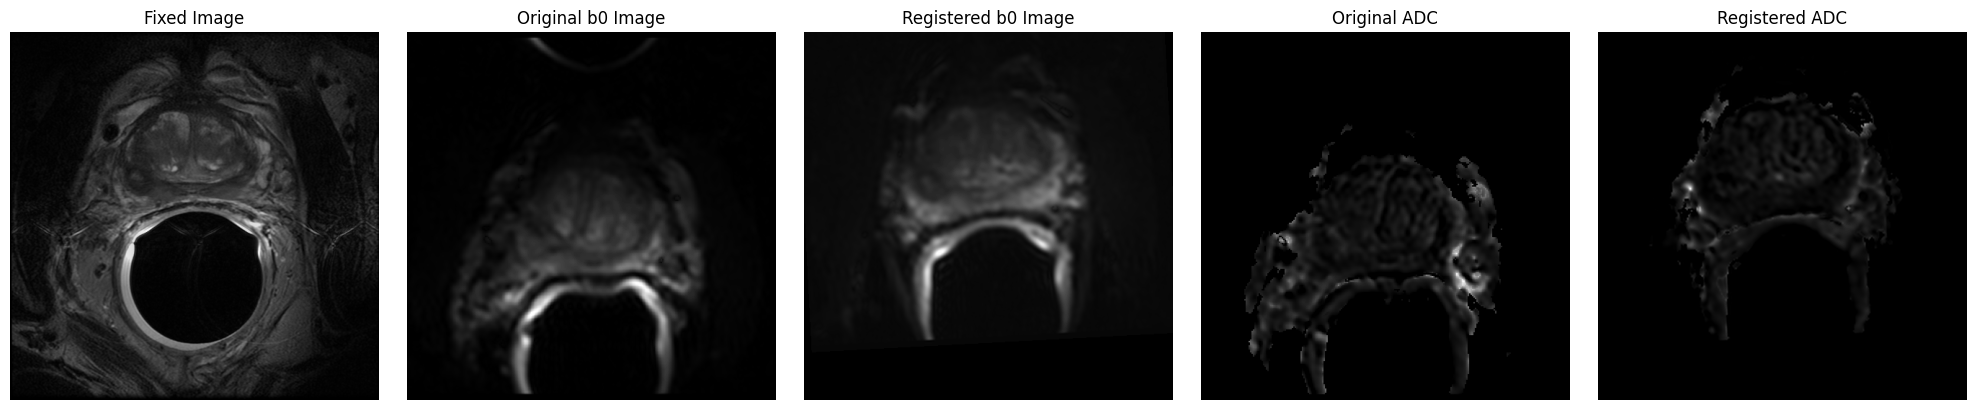

In [16]:

# Function to convert a 3D SimpleITK image to a 2D NumPy array
def extract_slice_for_display(img, z_slice):
    return sitk.GetArrayFromImage(img[:, :, z_slice])

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed_img)
elastixImageFilter.SetMovingImage(b0_img)
elastixImageFilter.SetParameterMap([
    # sitk.GetDefaultParameterMap('rigid')
    sitk.ReadParameterFile('ElastixModelZoo/models/Par0043/Par0043rigid.txt'), # GOOD
    # sitk.ReadParameterFile('ElastixModelZoo/models/Par0001/Par0001translation.txt'),
    # sitk.ReadParameterFile('ElastixModelZoo/models/Par0001/Par0001rigid.txt'),
])
elastixImageFilter.Execute()

transformParameterMap = elastixImageFilter.GetTransformParameterMap()

transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(transformParameterMap)
transformixImageFilter.SetMovingImage(adc)
transformixImageFilter.Execute()

# Get the result image
registered_adc = transformixImageFilter.GetResultImage()

# Clip the values outside the expected range using SimpleITK's Threshold function
registered_adc = sitk.Threshold(registered_adc, lower=0., upper=float(sitk.GetArrayFromImage(registered_adc).max()), outsideValue=0.)

sitk.WriteImage(registered_adc, "ADC_reg.nii.gz")

original_b0_slice = extract_slice_for_display(b0_img, b0_img.GetSize()[-1]//2)
original_adc_slice = extract_slice_for_display(adc, adc.GetSize()[-1]//2)
registered_b0_img = elastixImageFilter.GetResultImage()
registered_b0_slice = extract_slice_for_display(registered_b0_img, registered_b0_img.GetSize()[-1]//2)
registered_adc_img = registered_adc
registered_adc_slice = extract_slice_for_display(registered_adc_img, registered_adc_img.GetSize()[-1]//2)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(sitk.GetArrayFromImage(fixed_img[:, :, fixed_img.GetSize()[-1]//2]), cmap='gray')
axs[0].set_title('Fixed Image')
axs[1].imshow(original_b0_slice, cmap='gray')
axs[1].set_title('Original b0 Image')
axs[2].imshow(registered_b0_slice, cmap='gray')
axs[2].set_title('Registered b0 Image')
axs[3].imshow(original_adc_slice, cmap='gray')
axs[3].set_title('Original ADC')
axs[4].imshow(registered_adc_slice, cmap='gray')
axs[4].set_title('Registered ADC')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
InitializeTransform took 0.01s
Scales are estimated automatically.
Scales for transform parameters are: [1205.4573610690964, 1486.7639761314028, 593.870701580412, 1205.4573610690964, 1486.7639761314028, 593.870701580412, 1205.45736

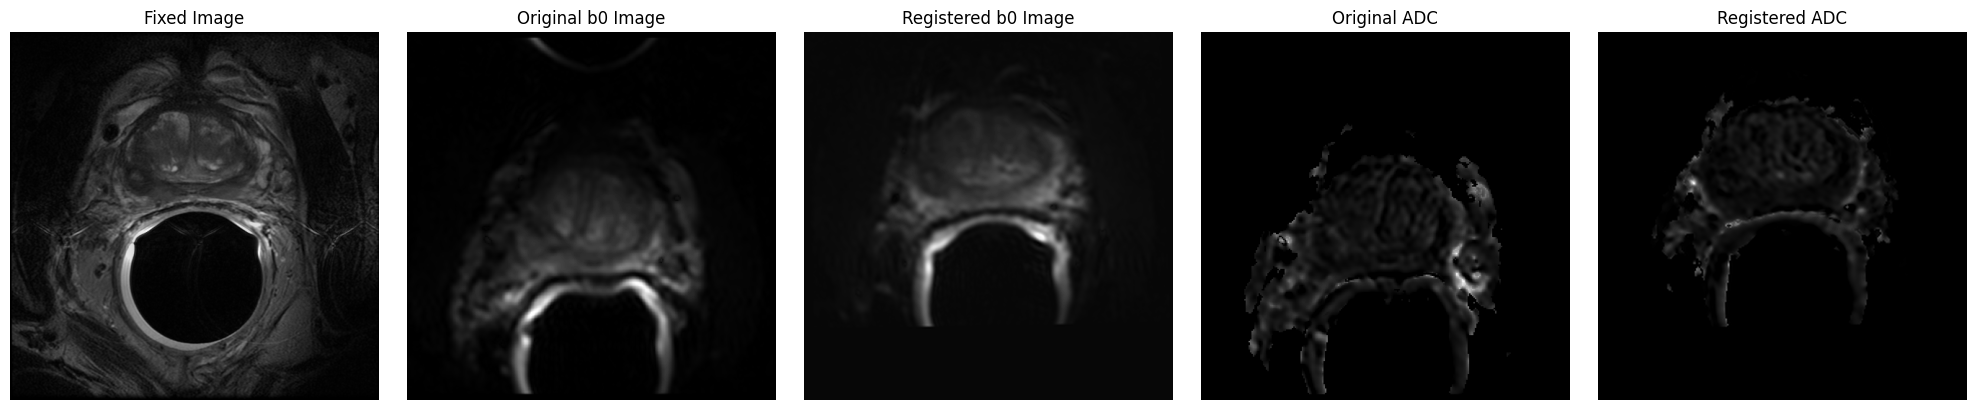

In [17]:

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed_img)
elastixImageFilter.SetMovingImage(b0_img)
elastixImageFilter.SetFixedMask(sitk.Cast(fixed_mask, sitk.sitkUInt8))
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap('affine'))
elastixImageFilter.Execute()

transformParameterMap = elastixImageFilter.GetTransformParameterMap()

transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(transformParameterMap)
transformixImageFilter.SetMovingImage(adc)
transformixImageFilter.Execute()

# Get the result image
registered_adc = transformixImageFilter.GetResultImage()

# Clip the values outside the expected range using SimpleITK's Threshold function
registered_adc = sitk.Threshold(registered_adc, lower=0., upper=float(sitk.GetArrayFromImage(registered_adc).max()), outsideValue=0.)

sitk.WriteImage(registered_adc, "ADC_masked_reg.nii.gz")

original_b0_slice = extract_slice_for_display(b0_img, b0_img.GetSize()[-1]//2)
original_adc_slice = extract_slice_for_display(adc, adc.GetSize()[-1]//2)
registered_b0_img = elastixImageFilter.GetResultImage()
registered_b0_slice = extract_slice_for_display(registered_b0_img, registered_b0_img.GetSize()[-1]//2)
registered_adc_img = registered_adc
registered_adc_slice = extract_slice_for_display(registered_adc_img, registered_adc_img.GetSize()[-1]//2)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(sitk.GetArrayFromImage(fixed_img[:, :, fixed_img.GetSize()[-1]//2]), cmap='gray')
axs[0].set_title('Fixed Image')
axs[1].imshow(original_b0_slice, cmap='gray')
axs[1].set_title('Original b0 Image')
axs[2].imshow(registered_b0_slice, cmap='gray')
axs[2].set_title('Registered b0 Image')
axs[3].imshow(original_adc_slice, cmap='gray')
axs[3].set_title('Original ADC')
axs[4].imshow(registered_adc_slice, cmap='gray')
axs[4].set_title('Registered ADC')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import glob
PARENT_DIR = '/Volumes/Siren/Prostate_data'

SUBJECT_MRI_FOLDER = 'MRI/'
T2_FILENAME = 'T2.nii.gz'
B0_FILENAME = 'b0.nii.gz'

for subject_dir in glob.glob(PARENT_DIR+'/*/'):
    print(subject_dir)

    t2s = [x for x in glob.glob(subject_dir+SUBJECT_MRI_FOLDER+'**/'+T2_FILENAME, recursive=True)]
    if not t2s:
        continue
    t2 = t2s[0]
    print(t2)

    for adc in glob.glob(subject_dir+SUBJECT_MRI_FOLDER+T2_FILENAME, recursive=True):
        print(adc)
        if 'registered' not in adc:
            print('not registered')
            !antsRegistrationSyN.sh -d 3 -f {subject+'/T2/registered_T2.nii.gz'} -m {adc} -o {adc[:-7]+'_


In [21]:
import pydicom

# Specify the path to your DICOM data
dicom_path = '/Volumes/Siren/Prostate_data/1102/MRI/Raw_junk/Mr_Pelvis/Ax_DWI_Focus_(research)/IM-0013-0157.dcm'

# Read the DICOM data
ds = pydicom.dcmread(dicom_path)

# Extract the gradient directions
if 'DiffusionGradientDirectionSequence' in ds:
    bvecs = ds.DiffusionGradientDirectionSequence
elif 'DiffusionGradientOrientation' in ds:
    bvecs = ds.DiffusionGradientOrientation
else:
    bvecs = None

# Extract the b-values
if 'DiffusionBValue' in ds:
    bvals = ds.DiffusionBValue
else:
    bvals = None

# Print the gradient directions and b-values
print('Gradient directions:', bvecs)
print('B-values:', bvals)

Gradient directions: None
B-values: None


In [3]:
import numpy as np
import nibabel as nib
from dipy.reconst.dti import TensorModel
from dipy.core.gradients import gradient_table
import matplotlib.pyplot as plt

# Load your DWI data and b-values
dwi_data = nib.load('./DWI_Research.nii.gz').get_fdata()
bvals = np.loadtxt('DWI_Research.bval')
bvecs = np.loadtxt('DWI_Research.bvec')

# normalize vectors
print(bvecs)
norms = np.linalg.norm(bvecs, axis=1)
bvecs[norms > 0] /= norms[norms > 0][:, None]

# Create a GradientTable object
gtab = gradient_table(bvals, bvecs)

# Create a tensor model
tensor_model = TensorModel(gtab)

# Create a tensor model
tensor_model = TensorModel(bvals)

# Fit the tensor model to the DWI data
tensor_fit = tensor_model.fit(dwi_data)

# Calculate the ADC map
adc_map = tensor_fit.adc()

# Select a 2D slice to visualize
slice_index = adc_map.shape[2] // 2
slice_data = adc_map[:, :, slice_index]

# Display the slice using matplotlib
plt.imshow(slice_data, cmap='gray')
plt.colorbar()
plt.title('ADC Map Slice')
plt.show()


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


ValueError: The vectors in bvecs should be unit (The tolerance can be modified as an input parameter)